In [10]:
import torch
import torchvision
import random
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PATH = './emnist.pth'

## Download/load data

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5), (0.5))
    ]
)

data_set = torchvision.datasets.EMNIST(
    root='./data',
    split="byclass",
    train=True,
    download=True, 
    transform=transform
)

100%|██████████| 561753746/561753746 [00:15<00:00, 37445731.10it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [11]:
import string
# removing upper case letters
uppers = np.arange(10,36)

pics = np.array(data_set.data)
targets = np.array(data_set.targets)

targets_indx = np.arange(len(targets))

#stores indexes of corresponding pics of classes
new_targets= []

for i in range(len(targets)):

    if targets[i] not in uppers:
        new_targets.append(targets_indx[i])

In [12]:
data_pics = pics[new_targets]
data_target=targets[new_targets]

In [13]:
# classes uneven
# finding class with least amount and using that number for all classes
frequency_dict = {item: np.count_nonzero(data_target == item) for item in np.unique(data_target)}

min_key = min(frequency_dict, key=frequency_dict.get)
min_value = frequency_dict[min_key]

print("Minimum key:", min_key)
print("Minimum amount:", min_value)

class_dict = {key: value for key, value in data_set.class_to_idx.items() if key not in list(string.ascii_uppercase)}

value = {i for i in class_dict if class_dict[i]==min_key}
print("min value key:",value)


Minimum key: 45
Minimum amount: 1896
min value key: {'j'}


In [14]:
# get even amount of pitures for every class
n = min_value
u = pd.unique(data_target)

class_indexs= {x: [] for x in u}

for class_num in u:
    for j in range(len(data_target)):
        if data_target[j] == class_num and len(class_indexs[class_num]) <n:
            class_indexs[class_num].append(j)
        

In [15]:
even_pics= []
even_targets = []

for key in class_indexs.keys():

    for j in range(n):
        even_pics.append( data_pics[class_indexs[key][j]] )
        even_targets.append( key )

In [16]:
#
for i,target in enumerate(even_targets):
    if target > 9:
        even_targets[i] = target - 26

print(np.unique(even_targets))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [17]:
for key in class_dict.keys():

    if class_dict[key] > 9 :
        class_dict[key] -= 26 
print(class_dict)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}


In [41]:
# from collections import Counter

# c = 0 
# for i in Counter(even_targets).keys():

#     c+=(Counter(even_targets)[i] - 1896)
    
# print(c)

0


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(even_pics), np.array(even_targets),
                                                     test_size=0.2, random_state=1)

/var/folders/fv/nwc5x101553470vxrsy344_40000gn/T/ipykernel_80831/327268793.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 54604 + 1) instead
  n= np.random.random_integers(0,len(y_train))


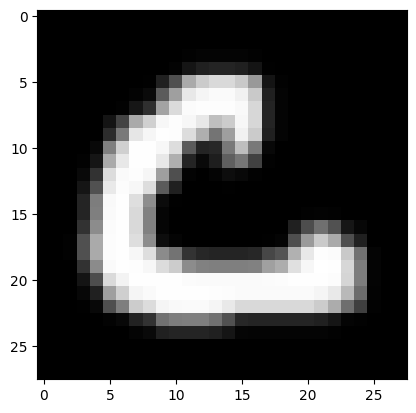

12
C


In [21]:
# pitures are reflected 
n= np.random.random_integers(0,len(y_train))
plt.imshow( np.transpose(X_train[n]) ,cmap='gray')
plt.show()
print(y_train[n])

for i in data_set.class_to_idx.keys():
    if data_set.class_to_idx[i]== y_train[n]:
        print(i)

In [22]:
# transposeing all pictures
transposed_images_tr = np.zeros( [len(y_train), 28, 28] )
for i,pic in enumerate(X_train):
    transposed_images_tr[i,:,:] = pic.transpose()

transposed_images_tst = np.zeros( [len(y_test), 28, 28] )
for i,pic in enumerate(X_test):
    transposed_images_tst[i,:,:] = pic.transpose()


In [23]:
from torch.utils.data import DataLoader, TensorDataset



train_dataset = TensorDataset( torch.Tensor(transposed_images_tr), torch.Tensor(y_train) )
test_dataset = TensorDataset( torch.Tensor(transposed_images_tst), torch.Tensor(y_test) )

In [24]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [25]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=128 * 3 * 3, out_features=512)  
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=  36)  # 62 - 26 classes 
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)  # Reshape before fully connected layers
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = CNN()

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

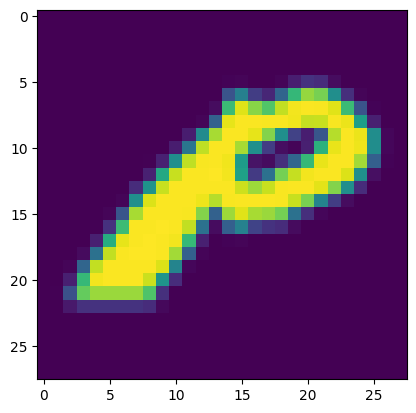

tensor(25.)
p


In [27]:
for inputs,labels in train_loader:
    plt.imshow(inputs[0])
    plt.show()
    print(labels[0])
    
    for i in data_set.class_to_idx.keys():
        if labels[0] < 10:
            if data_set.class_to_idx[i]== labels[0]:
                print(i)
                break
        elif data_set.class_to_idx[i]== labels[0]+26:
                print(i)
    break

In [32]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for inputs,labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1], Loss: 0.0393


In [39]:
predicted

tensor([17,  1, 34, 17, 22, 17, 10,  6, 32,  9, 28, 18, 22,  8, 35, 18, 25,  6,
        20, 14])

In [33]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model(inputs.unsqueeze(1))

        _, predicted = torch.max(outputs.data, 1)

        total += labels.long().size(0)
        
        correct += (predicted == labels.long()).sum().item()

print(f'Accuracy on test data: {100 * correct / total:.2f}%')

Accuracy on test data: 86.42%
